In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
from torchinfo import summary
import R2LOSS as r2
from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
import cv2
import unet as u
from utils import save_checkpoint, load_checkpoint, save_some_examples
import config
from dataset import MapDataset
from torch.nn import functional as F
from torch.cuda.amp import autocast
from PIL import Image as im

class My_Custom_Loss(nn.Module):
    
    def __init__(self):
        super(My_Custom_Loss, self).__init__()
    
    def forward(self, y_pred, y):
        
        numerator = torch.sum((y - torch.mean(y))*(y_pred - torch.mean(y_pred)))
        denominator = torch.sqrt(torch.sum((y - torch.mean(y))**2)*torch.sum((y_pred - torch.mean(y_pred))**2))
        L2 = F.mse_loss(y_pred, y, reduction="mean")
                       
        return L2*(1-numerator/denominator)

D:\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] Не найден указанный модуль
  warn(f"Failed to load image Python extension: {e}")


In [5]:
# device = 'cuda'
# model = model.to(device)


# model = u.UNet(in_channels=1,
#              out_channels=1,
#              n_blocks=3,
#              start_filts=64,
#              activation='leaky',
#              conv_mode='same',
#              dim=2)

# summary(model, (1,1,256,256))

In [2]:
def train_fn(
    model, train_loader, val_loader, opt, loss_f
):
    train_loop = tqdm(train_loader, leave=True)
    train_loss = 0

    for idx, (x, y) in enumerate(train_loop):

        x = x.to(torch.float16).to(config.DEVICE)
        y = y.to(torch.float16).to(config.DEVICE)

        opt.zero_grad()
        
        with autocast():
            
            y_pred = model(x)
            loss = loss_f.forward(y_pred, y)

            loss.backward()
            opt.step()

            train_loss += loss
        
        if idx % 10 == 0:
            train_loop.set_postfix(
                loss=loss,
            )
        
    train_loss /= len(train_loader)
        
    if config.VALIDATE:
        
        torch.cuda.empty_cache()
        val_loss = 0
        model.eval()
        
        with torch.no_grad():
            
            for idx, (x, y) in enumerate(val_loader):

                x = x.to(torch.float16).to(config.DEVICE)
                y = y.to(torch.float16).to(config.DEVICE)
                
                with autocast():
                    y_pred = model(x)
                    loss = loss_f.forward(y_pred, y)
                    val_loss += loss
        
        val_loss /= len(val_loader)
        model.train()
        
    return train_loss, val_loss


def main():
    
    losses = []
    
    model = u.UNet(in_channels=1,
             out_channels=1,
             n_blocks=3,
             start_filts=64,
             activation='leaky',
             conv_mode='same',
             dim=2)
        
    model = model.to(config.DEVICE)
    opt = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
    loss_f = nn.MSELoss()
#     loss_f = My_Custom_Loss()

    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN, model, opt, config.LEARNING_RATE,
        )
        
    train_dataset = MapDataset(root_dir=config.TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
    )
    
    val_dataset = MapDataset(root_dir=config.VAL_DIR)
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.VAL_BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
    )
    
    df=open('history.txt','w')
    
    for epoch in range(config.NUM_EPOCHS):
        
        train_loss, val_loss = train_fn(
            model, train_loader, val_loader, opt, loss_f,
        )
        
        train_loss = train_loss.to('cpu').detach().numpy()
        val_loss = val_loss.to('cpu').detach().numpy()
        
        with open("history.txt", "a+") as file_object:
            
            file_object.seek(0)
            file_object.write(str(train_loss) + ' ' + str(val_loss) + '\n')

        if config.SAVE_MODEL and epoch % 10 == 0:
            save_checkpoint(model, opt, filename=config.CHECKPOINT_MODEL + str(epoch) + '.pth.tar')

        # save_some_examples(model, val_loader, epoch, folder="evaluation")
        
    df.close()

In [ ]:
main()

100%|██████████████| 250/250 [01:38<00:00,  2.54it/s, loss=tensor(0.2390, device='cuda:0', grad_fn=<MseLossBackward0>)]


=> Saving checkpoint


100%|██████████████| 250/250 [00:27<00:00, 12.36it/s, loss=tensor(0.0911, device='cuda:0', grad_fn=<MseLossBackward0>)]

In [2]:
history = np.loadtxt('history.txt')

train_losses = history[:, 0]
val_losses = history[:, 1]

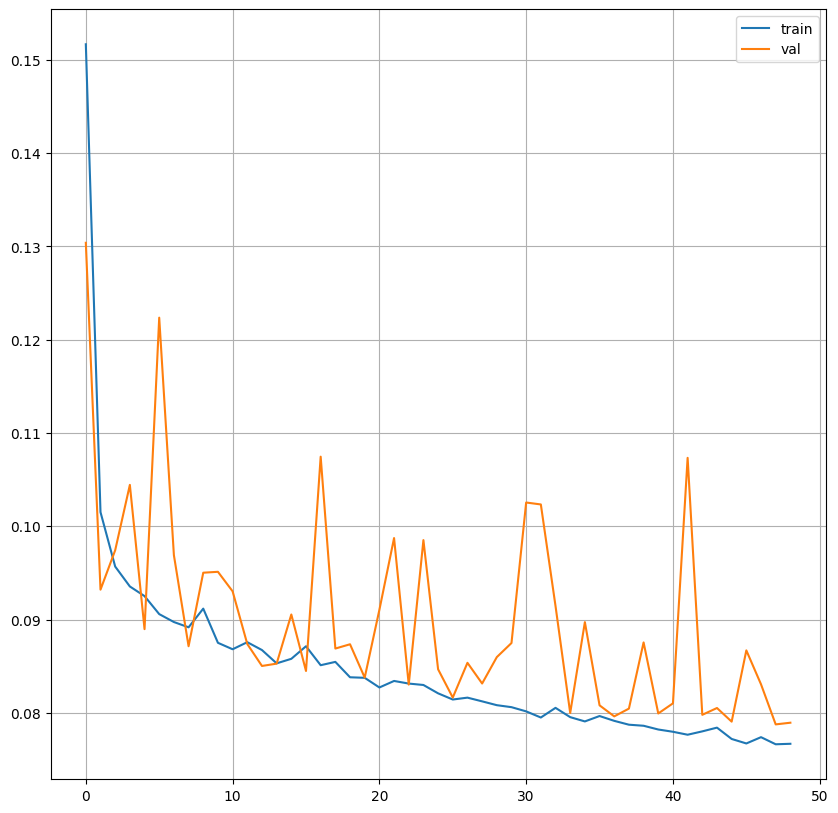

In [3]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

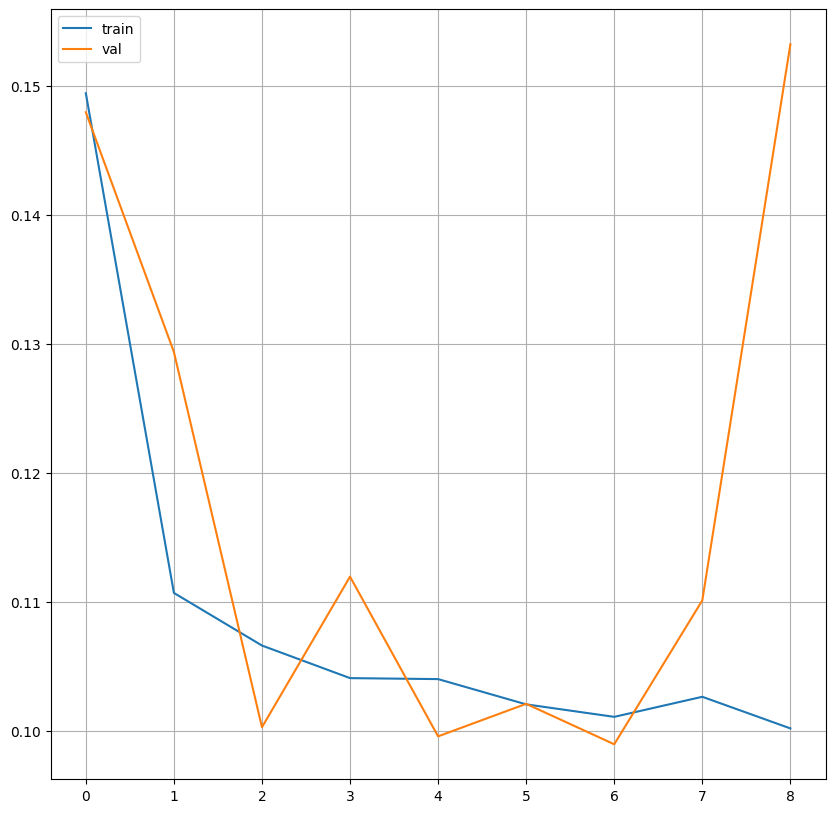

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

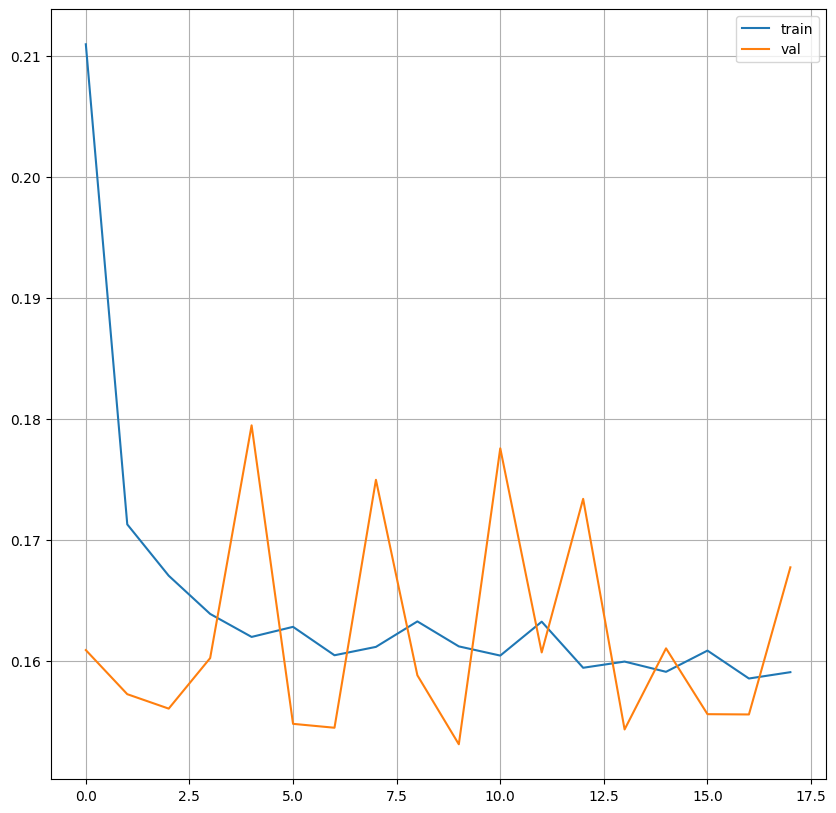

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

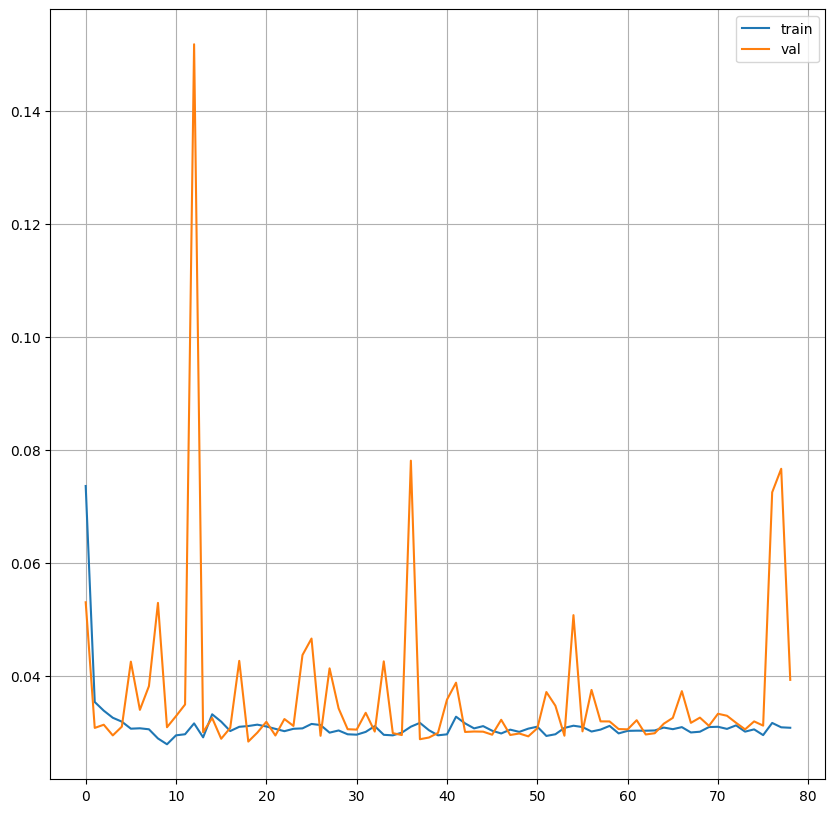

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

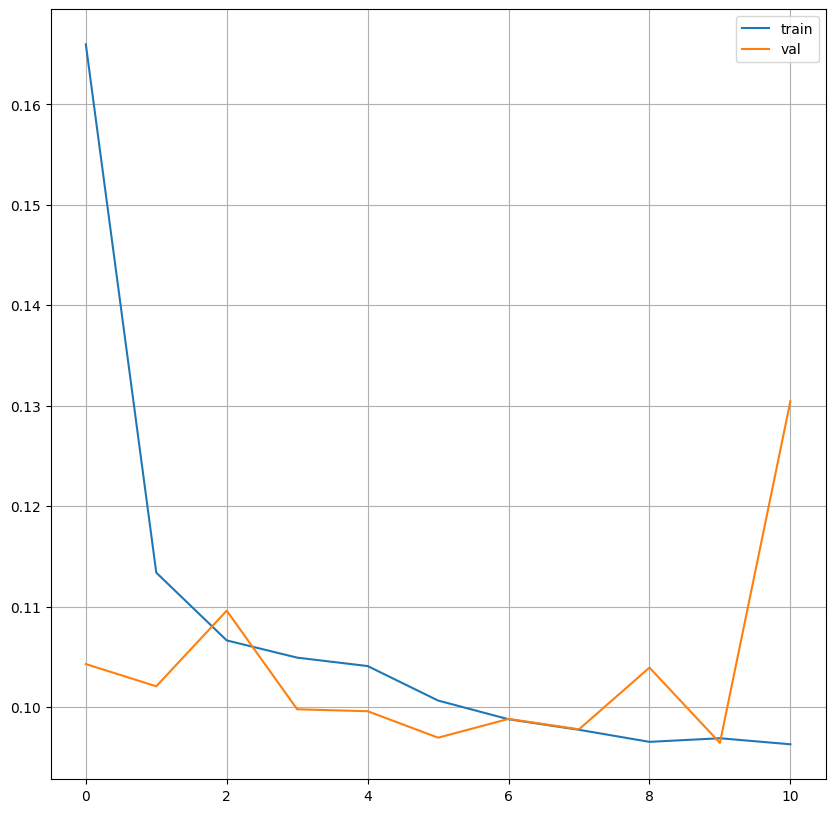

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

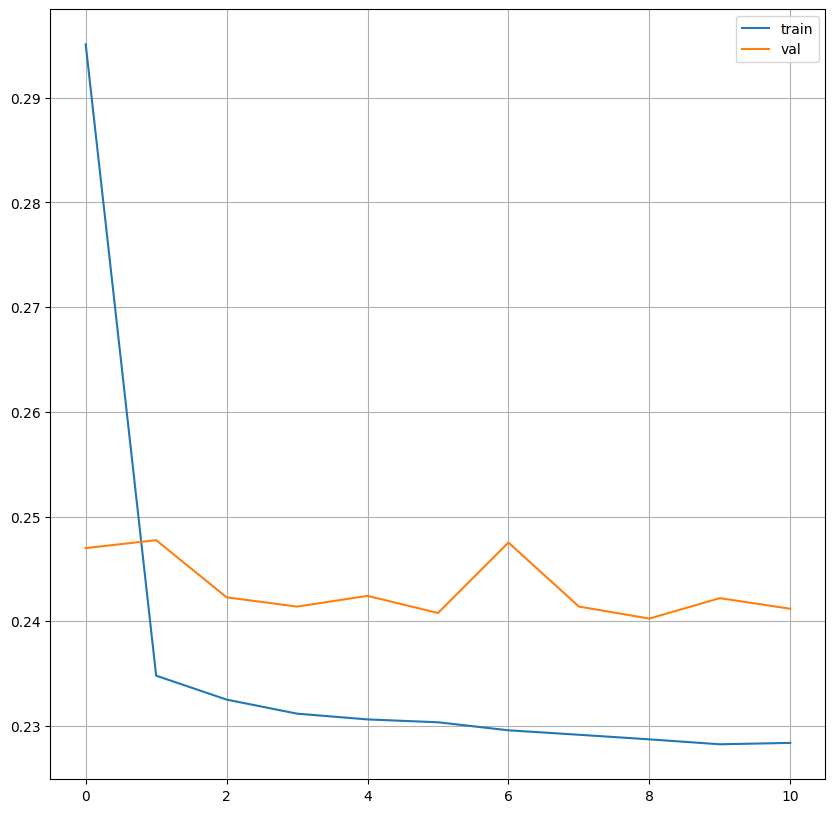

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

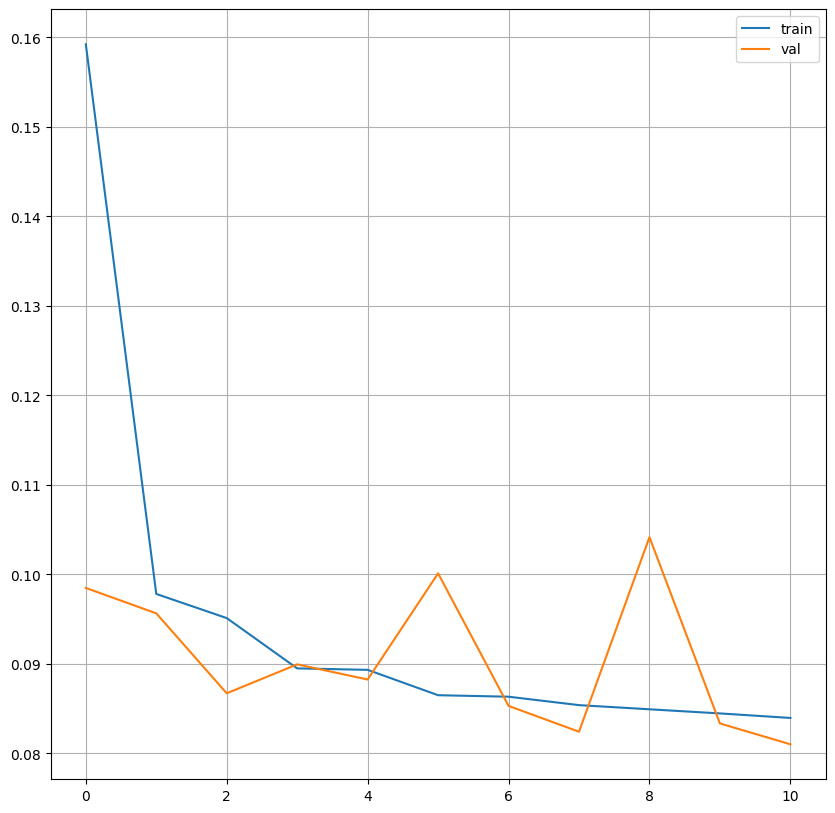

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()
# ax.set_xlim(0, 75)

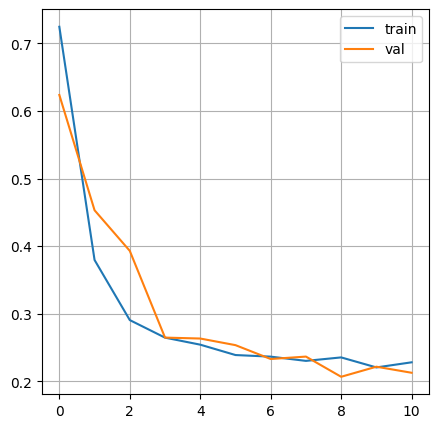

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()

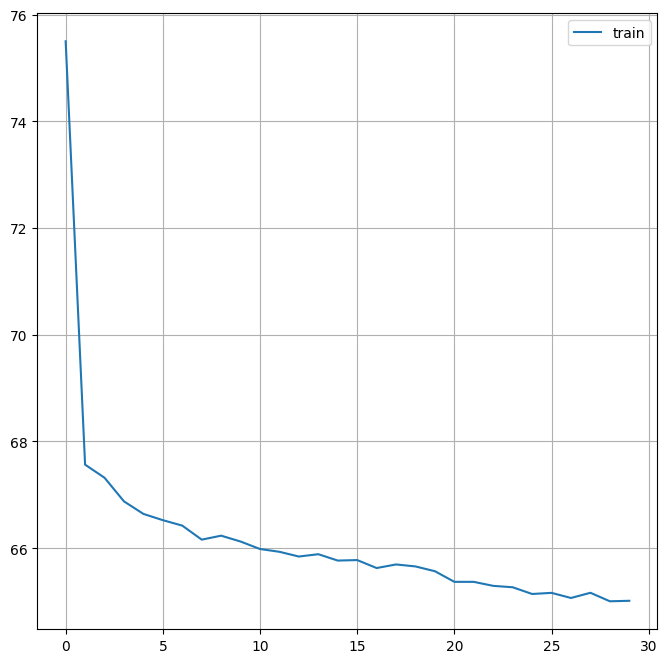

In [48]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(train_losses, label = 'train')
# ax.plot(val_losses, label = 'val')

ax.legend()
ax.grid()

In [25]:
res = []
for i, j in enumerate(loss_history):
    res.append(loss_history[i].to('cpu').detach().numpy())

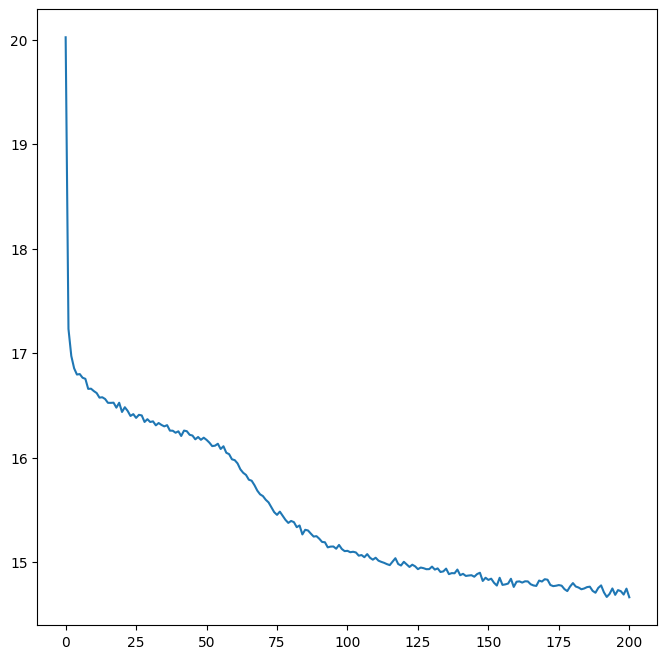

In [28]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(res)

Mini-batch visualisation

In [3]:
train_dataset = MapDataset(root_dir=config.TRAIN_DIR)
train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
    )

In [4]:
x, y = next(iter(train_loader))

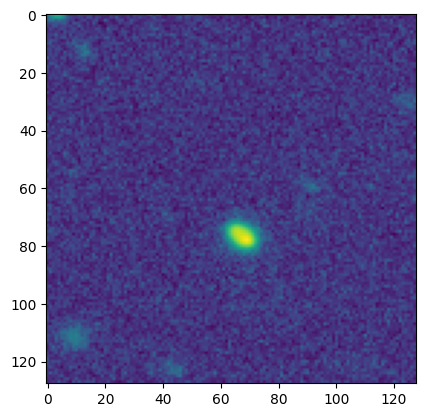

In [5]:
fig, ax = plt.subplots()

ax.imshow(x[0][0].numpy())

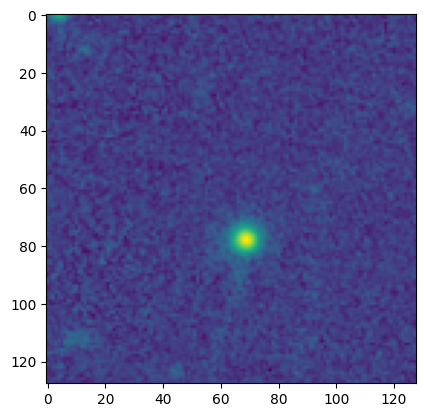

In [6]:
fig, ax = plt.subplots()

ax.imshow(y[0][0].numpy())

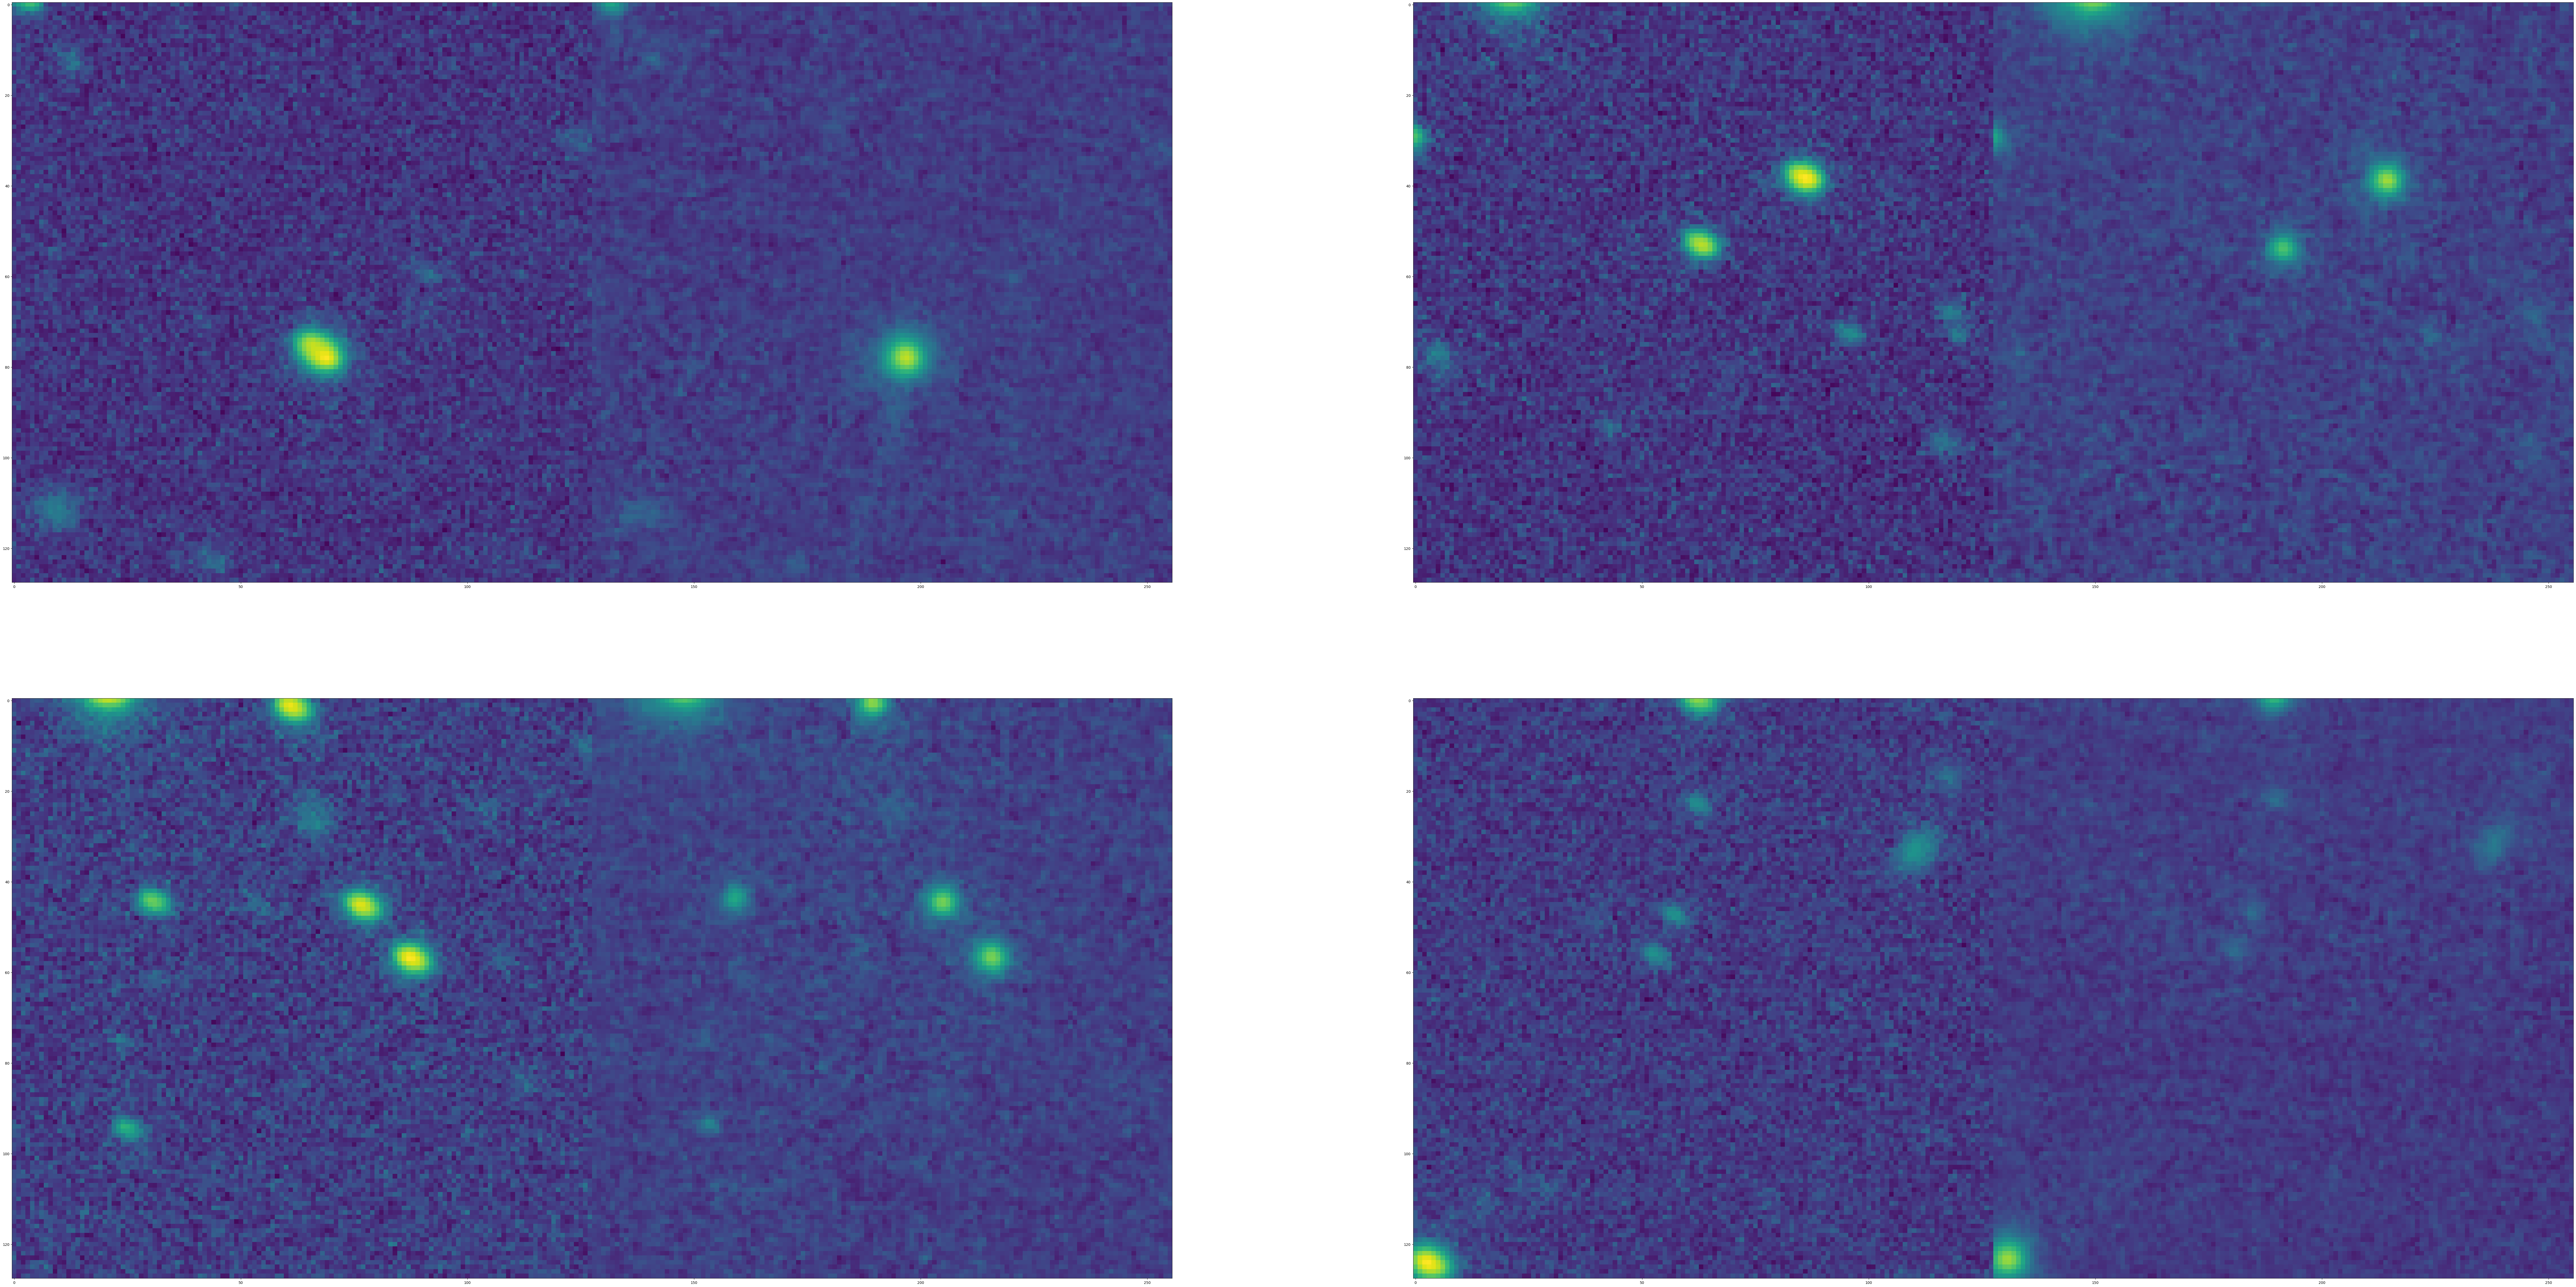

In [7]:
plots = []
for i in range(config.BATCH_SIZE):
    x0 = x[i][0].numpy()
    y0 = y[i][0].numpy()
    im = np.concatenate((x0,y0), axis=1)
    plots.append(im)
    
fig = plt.figure(figsize=(128, 64))
columns = 2
rows = 2
for i in range(columns*rows):
    img = plots[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

Model results visualization

In [7]:
model = u.UNet(in_channels=1,
             out_channels=1,
             n_blocks=3,
             start_filts=64,
             activation='leaky',
             conv_mode='same',
             dim=2)

checkpoint_MD_PS = torch.load('checkpoints_128/model_40.pth.tar', map_location=config.DEVICE)
model.load_state_dict(checkpoint_MD_PS["state_dict"])
model = model.to('cpu')
# device = 'cuda'
# model = model.to(device)

# summary(model, (1,1,256,256))

In [11]:
from astropy.wcs import WCS
from scale import scale_M
from astropy.coordinates import SkyCoord

net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'transinet_crts.caffemodel')

In [7]:
%%time

k = 7

M_hdu = fits.open('data/prepro/'+str(k)+'_M.fits')[0]
M_wcs = WCS(M_hdu.header)
M = M_hdu.data
P = fits.open('data/prepro/'+str(k)+'_P.fits')[0].data
    
i = 128
j = 128

P_crops = []
M_crops = []
res = []
numbers = []

boffset, ps_median, bsoften = sigma_clipped_stats(M[200:1896, 200:1896], maxiters=0)

while i < np.shape(M)[0]:

    while j < np.shape(M)[1]:

        try:
            M_crop, P_crop = M[i-128:i+128, j-128:j+128].copy(), P[i-128:i+128, j-128:j+128].copy()
            M_scaled = scale_M(25,
                      25,
                      M_crop,
                      P_crop,
                      bsoften,
                      boffset,)
            
            x = torch.from_numpy(M_scaled).view(1,1,256,256).to(torch.float32)

            out_md = MD_PS(x.to('cpu'))
            M_scaled = out_md.detach().numpy()[0][0]
            
            y = torch.from_numpy(P_crop.astype(np.float32)).view(1,1,256,256).to(torch.float32)

            out_ps = PS_MD(y.to('cpu'))
            P_crop = out_ps.detach().numpy()[0][0]

        except ValueError:
            M_scaled = np.zeros((256,256))
            P_crop = np.zeros((256,256))
            out = np.zeros((256,256))
            print('err1')

        try:

            M_scaled -= M_scaled.min()
            M_scaled /= M_scaled.max()
            M_scaled *= 255

            P_crop -= P_crop.min()
            P_crop /= P_crop.max()
            P_crop *= 255

            M_data = im.fromarray((M_scaled).astype(np.uint8))
            M_data.save('M_im.jpeg')
            M_im = cv2.imread('M_im.jpeg')
            M_img = cv2.cvtColor(M_im, cv2.COLOR_BGR2GRAY)

            P_data = im.fromarray((P_crop).astype(np.uint8))
            P_data.save('P_im.jpeg')
            P_im = cv2.imread('P_im.jpeg')
            P_img = cv2.cvtColor(P_im, cv2.COLOR_BGR2GRAY)

            inp1 = cv2.dnn.blobFromImage(P_img, 1, (256,256))
            inp2 = cv2.dnn.blobFromImage(M_img, 1, (256,256))

            net.setInput(inp1, 'img0')
            net.setInput(inp2, 'img1')

            out = net.forward()[0][0]

        except ValueError:
            M_scale = np.zeros((256,256))
            P_crop = np.zeros((256,256))
            out = np.zeros((256,256))
            print('err2')

        M_crops.append(M_scaled)
        P_crops.append(P_crop)
        res.append(out)

#         try:
#             out_mean, out_median, out_std = sigma_clipped_stats(out)
#             out_threshold = out_median + (75*out_std)
#             out_tbl = find_peaks(out, out_threshold, box_size=25).as_array()
#             numbers.append(len(out_tbl))

#         except AttributeError:
#             numbers.append(0)

        j += 256

    i += 256
    j = 128


Wall time: 29min 24s


In [8]:
MM = np.concatenate((M_crops), axis=1)    
PP = np.concatenate((P_crops), axis=1) 
RR = np.concatenate((res), axis=1) 

M_result = MM[:, 0: 4096]
P_result = PP[:, 0: 4096]
R_result = RR[:, 0: 4096]

for k in range(1, 16):
    M_result = np.concatenate((M_result, MM[:, 4096*k:4096+4096*k]), axis=0)
    P_result = np.concatenate((P_result, PP[:, 4096*k:4096+4096*k]), axis=0)
    R_result = np.concatenate((R_result, RR[:, 4096*k:4096+4096*k]), axis=0)

M_data = im.fromarray((M_result).astype(np.uint8))
M_data.save('data/subtraction results/' + str(j) + '_M_result.jpeg')

P_data = im.fromarray((P_result).astype(np.uint8))
P_data.save('data/subtraction results/' + str(j) + '_P_result.jpeg')

R_data = im.fromarray((R_result).astype(np.uint8))
R_data.save('data/subtraction results/' + str(j) + '_R_result.jpeg')

# np.savetxt('data/subtraction results/' + str(j) + 'numbers.txt', np.array((numbers)))

In [13]:
from astropy import units as un

In [14]:
world = SkyCoord(M_hdu.header['RA'] + ' ' + M_hdu.header['DEC'], unit=(un.hourangle, un.deg))
grb = np.asarray(M_wcs.world_to_pixel(world))

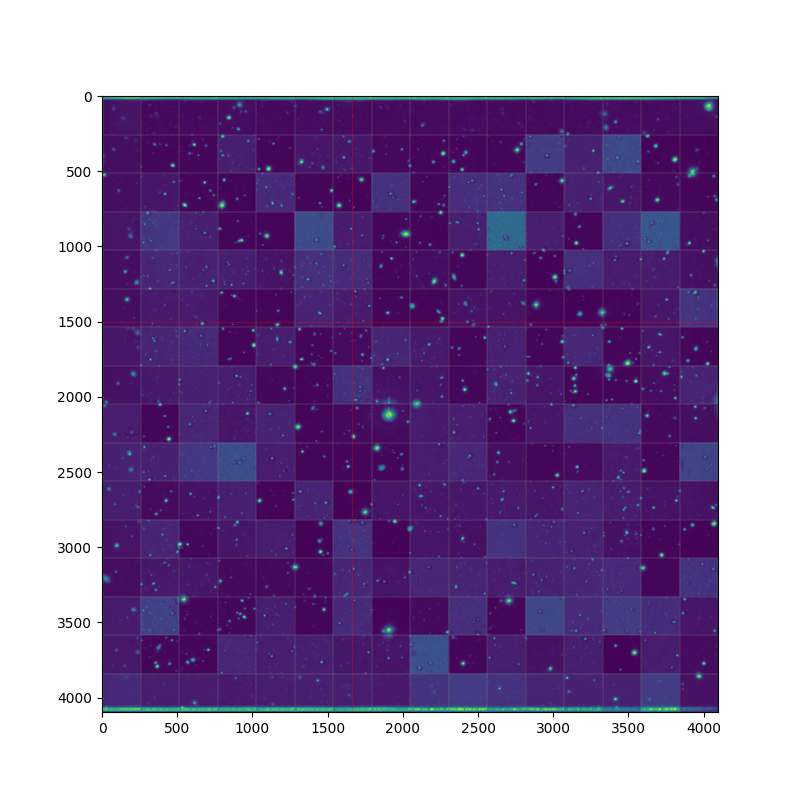

In [20]:
%matplotlib ipympl

fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(M_result)

ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

for i in range(16):
    ax.axvline(256*i, color='gray', lw=.25)
    ax.axhline(256*i, color='gray', lw=.25)

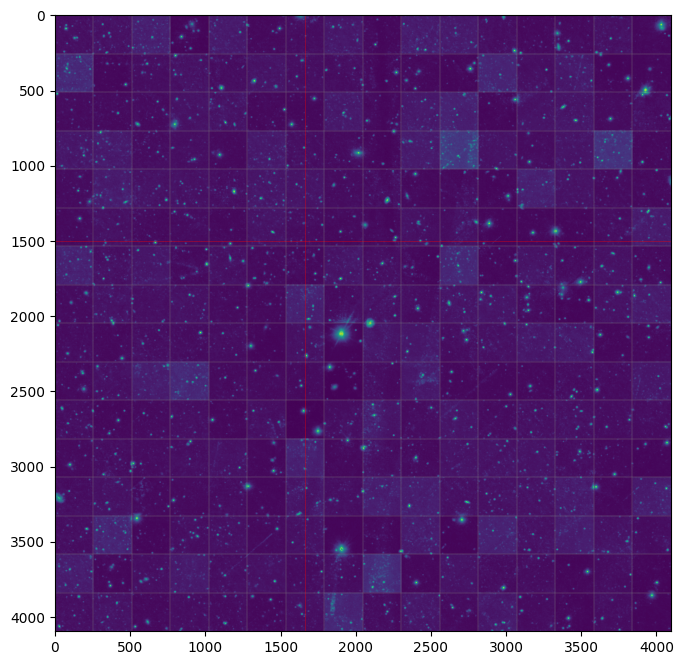

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(P_result)
ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

for i in range(16):
    ax.axvline(256*i, color='gray', lw=.25)
    ax.axhline(256*i, color='gray', lw=.25)

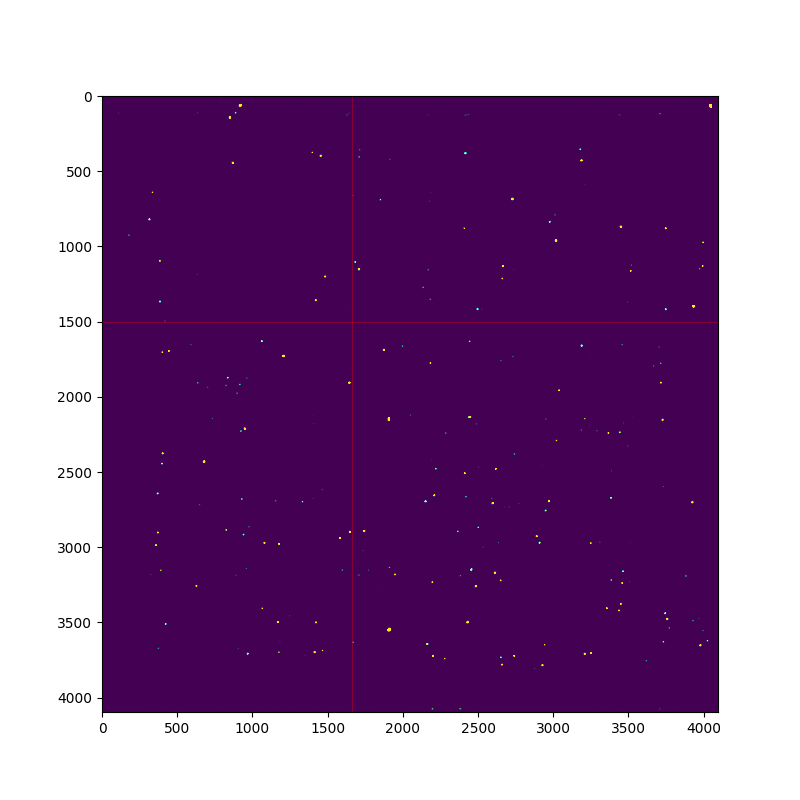

In [21]:
%matplotlib ipympl

fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(R_result, clim=(0,1))
ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

# for i in range(16):
#     ax.axvline(256*i, color='gray', lw=.25)
#     ax.axhline(256*i, color='gray', lw=.25)

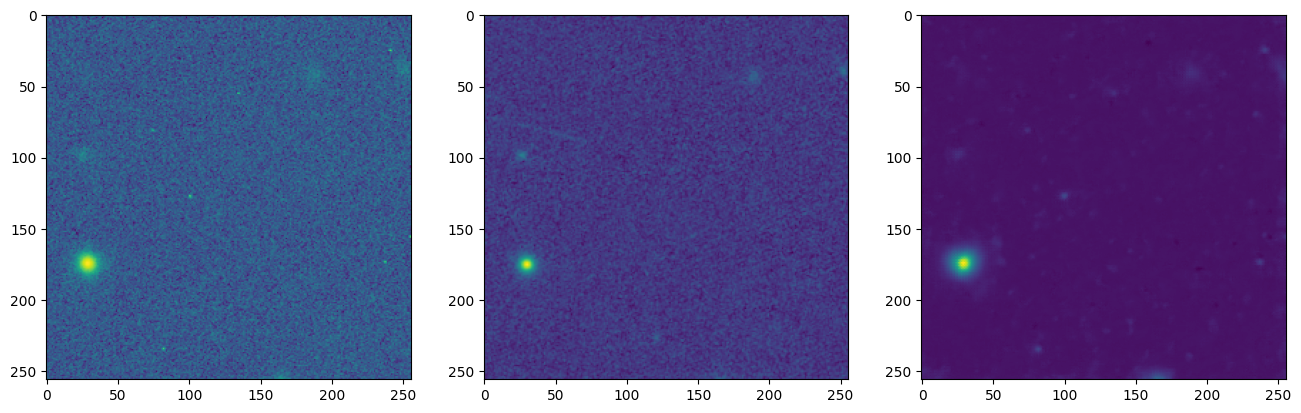

In [136]:
k = np.random.randint(0, len(os.listdir('data/val')))

dat = np.loadtxt('data/val/' + str(k) + '.txt')

x0 = dat[:, :256]
y0 = dat[:, 256:]

x = torch.from_numpy(x0).view(1,1,256,256).to(torch.float32)

model = model.to('cpu')
out = model(x.to('cpu'))
res = out.detach().numpy()[0][0]

plots = []
plots.append(x0)
plots.append(y0)
plots.append(res)
    
fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 1

for i in range(columns*rows):
    img = plots[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    
plt.show()

0.3816081345688044 0.4300996807216931 -0.05107153030295315 0.2560999962795505


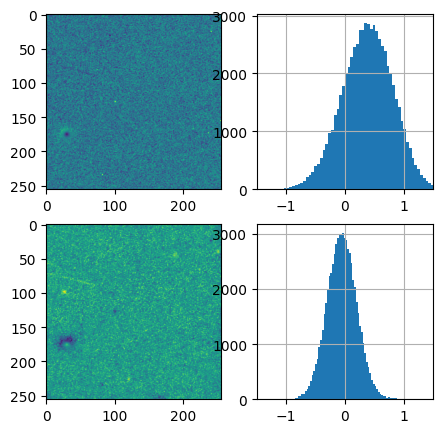

In [137]:
fig, axs = plt.subplots(2,2, figsize=(5,5))

axs[0][0].imshow(x0 - y0)
a,b,c = axs[0][1].hist((x0 - y0).ravel(), bins = 100) 
axs[0][1].set_xlim(-1.5,1.5)
# axs[0][1].axvline(0, color='k')
axs[0][1].grid()

axs[1][0].imshow(y0 - res)
a,b,c = axs[1][1].hist((res - y0).ravel(), bins = 100) 
axs[1][1].set_xlim(-1.5,1.5)
# axs[0][1].axvline(0, color='k')
axs[1][1].grid()

print((x0-y0).mean(), (x0-y0).std(), (res-y0).mean(), (res-y0).std())

In [47]:
net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'transinet_crts.caffemodel')

In [138]:
M_scaled = res
M_scaled -= M_scaled.min()
M_scaled /= M_scaled.max()
M_scaled *= 255

P_crop = y0
P_crop -= P_crop.min()
P_crop /= P_crop.max()
P_crop *= 255

M_data = im.fromarray((M_scaled).astype(np.uint8))
M_data.save('M_im.jpeg')
M_im = cv2.imread('M_im.jpeg')
M_img = cv2.cvtColor(M_im, cv2.COLOR_BGR2GRAY)

P_data = im.fromarray((P_crop).astype(np.uint8))
P_data.save('P_im.jpeg')
P_im = cv2.imread('P_im.jpeg')
P_img = cv2.cvtColor(P_im, cv2.COLOR_BGR2GRAY)

20


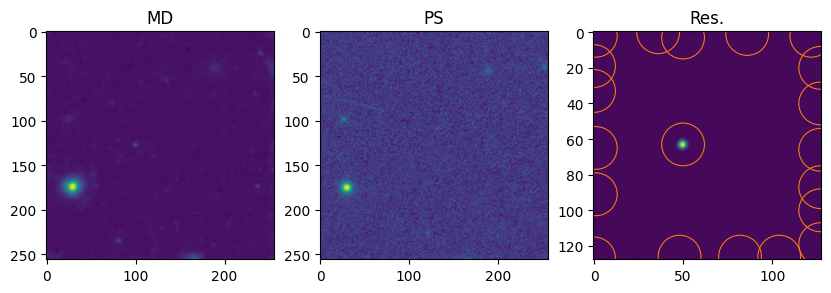

In [139]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(10, 10))

inp1 = cv2.dnn.blobFromImage(P_img, 1, (128,128))
inp2 = cv2.dnn.blobFromImage(M_img, 1, (128,128))

net.setInput(inp1, 'img0')
net.setInput(inp2, 'img1')

out = net.forward()
std = out.std()

# out[0][0][out[0][0] < np.sqrt(std)/100] = 0
# out[0][0][out[0][0] >= np.sqrt(std)/100] = 1

ax1.imshow(M_img)
# ax1.axvline(x=128, alpha = .5, lw=.5, c='k')
# ax1.axhline(y=128, alpha = .5, lw=.5, c='k')

ax1.set_title('MD')

ax2.imshow(P_img)
ax2.set_title('PS')

ax3.imshow(out[0][0])
# ax3.axvline(x=128, alpha = .5, c='white', lw=.5)
# ax3.axhline(y=128, alpha = .5, c='white', lw=.5)

ax3.set_title('Res.')

out_mean, out_median, out_std = sigma_clipped_stats(out[0][0])

out_threshold = out_median + (5*out_std)
out_tbl = find_peaks(out[0][0], out_threshold, box_size=25).as_array()

out_positions = np.transpose((out_tbl ['x_peak'], out_tbl ['y_peak']))
out_apertures = CircularAperture(out_positions, r=12.0)
a = out_apertures.plot(ax3, color='C1', lw=.75, alpha=1)
print(len(out_tbl))